### Library

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch import Tensor
from typing import Type
import lightning.pytorch as pl 
import torchmetrics
import torchvision
from torchinfo import summary
from torchview import draw_graph 
from IPython.display import display 
import sympy as sp 
sp.init_printing(use_latex=True)
import pandas as pd
import matplotlib.pyplot as plt
import io, os
from PIL import Image
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import requests, zipfile

In [2]:
if torch.cuda.is_available(): 
    print(torch.cuda.get_device_name()) 
    print(torch.cuda.get_device_properties("cuda")) 
    print("Number of devices:",torch.cuda.device_count()) 
    device = ("cuda")
else:
    print("Only CPU is available...")
    device = ("cpu")

Only CPU is available...


### URLs

In [3]:
sample_data_url = "https://yizhoubucket.s3.us-east-2.amazonaws.com/Covid19DatasetSample.zip"
resnet50_weights_url = "https://yizhoubucket.s3.us-east-2.amazonaws.com/resnet50_weights.pth"
resnet50_gelu_weight_url="https://yizhoubucket.s3.us-east-2.amazonaws.com/resnet50_gelu__weights.pth"
resnet101_weights_url = "https://yizhoubucket.s3.us-east-2.amazonaws.com/resnet101_weights.pth"
resnet101_gelu_weight_url= "https://yizhoubucket.s3.us-east-2.amazonaws.com/resnet101_gelu__weights.pth"
chexnet_weights_url= "https://yizhoubucket.s3.us-east-2.amazonaws.com/chexnet_weights.pth"
chexnet_gelu_weights_url= "https://yizhoubucket.s3.us-east-2.amazonaws.com/chexnet_gelu_weights.pth"
chexnet201_weights_url= "https://yizhoubucket.s3.us-east-2.amazonaws.com/chexnet201_weights.pth"
chexnet201_gelu_weights_url= "https://yizhoubucket.s3.us-east-2.amazonaws.com/chexnet201_gelu_weights.pth"

### Download Sample Dataset

In [4]:
def download_and_extract_zip(url, download_path='.'):
    zip_file_name = url.split('/')[-1]
    if zip_file_name.endswith('.zip'):
        file_name = zip_file_name.split('.zip')[0]
    # Check if the ZIP file already exists in the download path
    if os.path.exists(os.path.join(download_path, file_name)):
        print(f"The file '{file_name}' already exists. No need to download.")
        return
        
    if response.status_code == 200:
        response = requests.get(url)
        zip_file = io.BytesIO(response.content)
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(download_path)
        print("Download and extraction successful.")
    else:
        print(f"Failed to download file. Status code: {response.status_code}")

download_and_extract_zip(sample_data_url)

The file 'Covid19DatasetSample' already exists. No need to download.


### Read sample dataset from the Covid19DatasetSample directory

In [5]:
directory_label_pairs={
    r"Covid19DatasetSample/COVID/images": 0,
    r"Covid19DatasetSample/Lung_Opacity/images": 1,
    r"Covid19DatasetSample/Normal/images": 2,
    r"Covid19DatasetSample/Viral Pneumonia/images": 3
}
def read_images_with_labels(directory_label_pairs):
    # Initialize an empty list to store image-label pairs
    image_list = []
    label_list = []

    # Loop through each directory-label pair
    for directory_path in directory_label_pairs:
        # print(directory_path)
        label = directory_label_pairs[directory_path]
        # Use glob to get a list of file paths matching a pattern (e.g., all JPEG files)
        # print(os.path.isdir(directory_path))
        # Loop through the image files and read each image using PIL
        for file_name in os.listdir(directory_path):
            image_files = os.path.join(directory_path,file_name)
            if image_files.lower().endswith('png'):
                try:
                    # Open the image file
                    img = Image.open(image_files).convert("RGB")
                    img = img.resize((224,224))
                    # Append the image and its label to the list
                    #image_label_pairs.append([image,label])
                    image_list.append(np.array(img))
                    label_list.append(label)

                except Exception as e:
                    print(f"Error reading image {image_files}: {e}")


    return np.array(image_list), np.array(label_list)

images, labels = read_images_with_labels(directory_label_pairs)


In [6]:
x_test = torch.Tensor(images).permute(0,3,1,2)
y_test = torch.Tensor(labels).to(torch.long)
print(x_test.shape)
print(y_test.shape)

torch.Size([200, 3, 224, 224])
torch.Size([200])


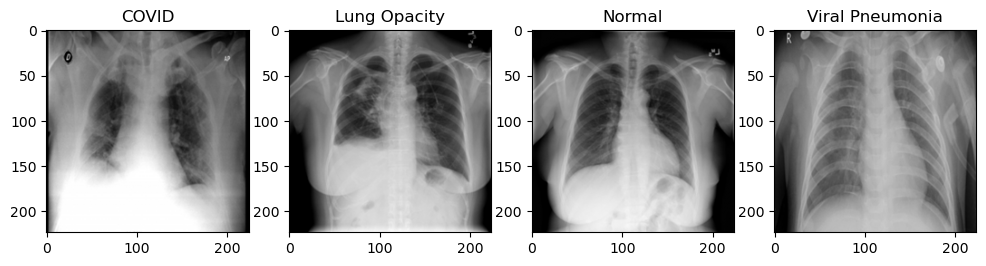

In [7]:
def label_to_string(labels):
    if labels == 0:
        title = "COVID"
    elif labels == 1:
        title = "Lung Opacity"
    elif labels == 2:
        title = "Normal"
    else:
        title = "Viral Pneumonia"
    return title
    
fig, axs = plt.subplots(1,4,figsize=(12,10))
axs[0].imshow(images[1]/255.0, cmap='gray')
title1 = label_to_string(labels[1])
axs[0].set_title(title1)

axs[1].imshow(images[55]/255.0, cmap='gray')
title2 = label_to_string(labels[55])
axs[1].set_title(title2)

axs[2].imshow(images[110]/255.0, cmap='gray')
title3 = label_to_string(labels[110])
axs[2].set_title(title3)

axs[3].imshow(images[160]/255.0, cmap='gray')
title4 = label_to_string(labels[160])
axs[3].set_title(title4)

plt.show()

### Use urls to get pre-trained weights

In [8]:
def download_weights(url, download_path='.'):
    weights_name = url.split('/')[-1]
    if os.path.exists(os.path.join(download_path, weights_name)):
        print(f"The file '{weights_name}' already exists. No need to download.")
        return
    response = requests.get(url)
    if response.status_code == 200:
        with open(os.path.join(download_path, weights_name), 'wb') as file:
            file.write(response.content)
        print(f"Download successful.")
    else:
        print(f"Failed to download file. Status code: {response.status_code}")

download_weights(resnet50_weights_url)
download_weights(resnet50_gelu_weight_url)
download_weights(resnet101_weights_url)
download_weights(resnet101_gelu_weight_url)
download_weights(chexnet_weights_url)
download_weights(chexnet_gelu_weights_url)
download_weights(chexnet201_weights_url)
download_weights(chexnet201_gelu_weights_url)

The file 'resnet50_weights.pth' already exists. No need to download.
The file 'resnet50_gelu__weights.pth' already exists. No need to download.
The file 'resnet101_weights.pth' already exists. No need to download.
The file 'resnet101_gelu__weights.pth' already exists. No need to download.
The file 'chexnet_weights.pth' already exists. No need to download.
The file 'chexnet_gelu_weights.pth' already exists. No need to download.
The file 'chexnet201_weights.pth' already exists. No need to download.
The file 'chexnet201_gelu_weights.pth' already exists. No need to download.


### ResNet50 Model

In [9]:
class ResNet50(pl.LightningModule):
    def __init__(self,input_shape, output_size, **kwargs):
        super().__init__(**kwargs)
        # Needs to always be applied to any incoming
        # image for this model. The Compose operation
        # takes a list of torchvision transforms and
        # applies them in sequential order, similar
        # to neural layers...
        self.normalize = torchvision.transforms.Compose([
            torchvision.transforms.Lambda(lambda x: x / 255.0),
            torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225]),
        ])
        # Besides just scaling, the images can also undergo
        # augmentation using torchvision. Again, we compose
        # these operations together - ranges are provided for
        # each of these augmentations.
        self.transform = torchvision.transforms.Compose([
            torchvision.transforms.RandomAffine(degrees=(-10.0,10.0),
                                                translate=(0.1,0.1),
                                                scale=(0.9,1.1),
                                                shear=(-10.0,10.0)),
            torchvision.transforms.RandomHorizontalFlip(0.5),
        ])
        self.resnet = torchvision.models.resnet50(weights=None, num_classes=output_size)
        self.mc_acc = torchmetrics.classification.Accuracy(task='multiclass',
                                                           num_classes=output_size)
        self.cce_loss = torch.nn.CrossEntropyLoss()

    def forward(self,x):
        y = x
        y = self.normalize(y)
        if self.training:
            y = self.transform(y)

        y = self.resnet(y)
        return y

    def predict(self,x):
        return torch.softmax(self(x),-1)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        x, y_true = train_batch
        y_pred = self(x)
        acc = self.mc_acc(y_pred,y_true)
        loss = self.cce_loss(y_pred,y_true)
        self.log('train_acc', acc, on_step=False, on_epoch=True)
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y_true = val_batch
        y_pred = self(x)
        acc = self.mc_acc(y_pred,y_true)
        loss = self.cce_loss(y_pred,y_true)
        self.log('val_acc', acc, on_step=False, on_epoch=True)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        return loss
    
    def test_step(self, test_batch, batch_idx):
        x, y_true = test_batch
        y_pred = self(x)
        acc = self.mc_acc(y_pred,y_true)
        loss = self.cce_loss(y_pred,y_true) 
        self.log('test_acc', acc, on_step=False, on_epoch=True)
        self.log('test_loss', loss, on_step=False, on_epoch=True) 
        return loss


In [10]:
resnet50 = ResNet50(x_test.shape[1:], len(torch.unique(y_test)))
resnet50.load_state_dict(torch.load('resnet50_weights.pth'))
resnet50.eval()
batch_size = 128

# Initialize empty arrays to store predictions and true labels
all_predictions = []
all_true_labels = []

# Make predictions in batches
with torch.no_grad():
    for i in range(0, len(x_test), batch_size):
        x_batch = x_test[i:i + batch_size]

        # Make predictions for the current batch
        batch_predictions = resnet50(x_batch)

        # Store predictions and true labels
        all_predictions.extend(torch.argmax(batch_predictions, dim=1).cpu().numpy())
        all_true_labels.extend(y_test[i:i + batch_size])

# Convert lists to NumPy arrays
all_predictions = np.array(all_predictions)
all_true_labels = np.array(all_true_labels)

accuracy = accuracy_score(all_true_labels, all_predictions)
report = classification_report(all_true_labels, all_predictions)
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", report)

Accuracy: 0.905
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.82      0.89        50
           1       0.88      0.90      0.89        50
           2       0.82      0.98      0.89        50
           3       0.98      0.92      0.95        50

    accuracy                           0.91       200
   macro avg       0.91      0.91      0.91       200
weighted avg       0.91      0.91      0.91       200



### ResNet50-GELU

In [11]:
from typing import Any, Callable, List, Optional, Union
def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)
class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.gelu = nn.GELU()
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.gelu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.gelu(out)

        return out

class Bottleneck(nn.Module):
    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.gelu = nn.GELU()
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.gelu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.gelu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.gelu(out)

        return out

class ResNet(nn.Module):
    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        num_classes: int = 1000,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                f"or a 3-element tuple, got {replace_stride_with_dilation}"
            )
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.gelu = nn.GELU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

#        for m in self.modules():
#            if isinstance(m, nn.Conv2d):
#                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
#            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
#                nn.init.constant_(m.weight, 1)
#                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck) and m.bn3.weight is not None:
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock) and m.bn2.weight is not None:
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        planes: int,
        blocks: int,
        stride: int = 1,
        dilate: bool = False,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups, self.base_width, previous_dilation, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.gelu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)


class ResNet50_GELU(pl.LightningModule):
    def __init__(self,input_shape, output_size, **kwargs):
        super().__init__(**kwargs)
        # Needs to always be applied to any incoming
        # image for this model. The Compose operation
        # takes a list of torchvision transforms and
        # applies them in sequential order, similar
        # to neural layers...
        self.normalize = torchvision.transforms.Compose([
            torchvision.transforms.Lambda(lambda x: x / 255.0),
            torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225]),
        ])
        # Besides just scaling, the images can also undergo
        # augmentation using torchvision. Again, we compose
        # these operations together - ranges are provided for
        # each of these augmentations.
        self.transform = torchvision.transforms.Compose([
            torchvision.transforms.RandomAffine(degrees=(-10.0,10.0),
                                                translate=(0.1,0.1),
                                                scale=(0.9,1.1),
                                                shear=(-10.0,10.0)),
            torchvision.transforms.RandomHorizontalFlip(0.5),
        ])
        self.resnet = ResNet(Bottleneck, [3, 4, 6, 3], output_size)
        self.mc_acc = torchmetrics.classification.Accuracy(task='multiclass',
                                                           num_classes=output_size)
        self.cce_loss = torch.nn.CrossEntropyLoss()

    def forward(self,x):
        y = x
        y = self.normalize(y)
        if self.training:
            y = self.transform(y)

        y = self.resnet(y)
        return y

    def predict(self,x):
        return torch.softmax(self(x),-1)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        x, y_true = train_batch
        y_pred = self(x)
        acc = self.mc_acc(y_pred,y_true)
        loss = self.cce_loss(y_pred,y_true)
        self.log('train_acc', acc, on_step=False, on_epoch=True)
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y_true = val_batch
        y_pred = self(x)
        acc = self.mc_acc(y_pred,y_true)
        loss = self.cce_loss(y_pred,y_true)
        self.log('val_acc', acc, on_step=False, on_epoch=True)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        return loss
    
    def test_step(self, test_batch, batch_idx):
        x, y_true = test_batch
        y_pred = self(x)
        acc = self.mc_acc(y_pred,y_true)
        loss = self.cce_loss(y_pred,y_true) 
        self.log('test_acc', acc, on_step=False, on_epoch=True)
        self.log('test_loss', loss, on_step=False, on_epoch=True) 
        return loss

### Evaluate the model

In [12]:
resnet50_gelu = ResNet50_GELU(x_test.shape[1:], len(torch.unique(y_test)))
resnet50_gelu.load_state_dict(torch.load('resnet50_gelu__weights.pth'))
resnet50_gelu.eval()
batch_size = 128

# Initialize empty arrays to store predictions and true labels
all_predictions1 = []
all_true_labels1 = []

# Make predictions in batches
with torch.no_grad():
    for i in range(0, len(x_test), batch_size):
        x_batch = x_test[i:i + batch_size]

        # Make predictions for the current batch
        batch_predictions = resnet50_gelu(x_batch)

        # Store predictions and true labels
        all_predictions1.extend(torch.argmax(batch_predictions, dim=1).cpu().numpy())
        all_true_labels1.extend(y_test[i:i + batch_size])

# Convert lists to NumPy arrays
all_predictions1 = np.array(all_predictions1)
all_true_labels1 = np.array(all_true_labels1)

accuracy1 = accuracy_score(all_true_labels1, all_predictions1)
report1 = classification_report(all_true_labels1, all_predictions1)
print(f"Accuracy: {accuracy1}")
print("Classification Report:\n", report1)

Accuracy: 0.825
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.62      0.76        50
           1       0.80      0.86      0.83        50
           2       0.69      0.94      0.80        50
           3       0.96      0.88      0.92        50

    accuracy                           0.82       200
   macro avg       0.85      0.82      0.82       200
weighted avg       0.85      0.82      0.82       200



### ResNet101

In [13]:
class ResNet101(pl.LightningModule):
    def __init__(self,input_shape, output_size, **kwargs):
        super().__init__(**kwargs)
        # Needs to always be applied to any incoming
        # image for this model. The Compose operation
        # takes a list of torchvision transforms and
        # applies them in sequential order, similar
        # to neural layers...
        self.normalize = torchvision.transforms.Compose([
            torchvision.transforms.Lambda(lambda x: x / 255.0),
            torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225]),
        ])
        # Besides just scaling, the images can also undergo
        # augmentation using torchvision. Again, we compose
        # these operations together - ranges are provided for
        # each of these augmentations.
        self.transform = torchvision.transforms.Compose([
            torchvision.transforms.RandomAffine(degrees=(-10.0,10.0),
                                                translate=(0.1,0.1),
                                                scale=(0.9,1.1),
                                                shear=(-10.0,10.0)),
            torchvision.transforms.RandomHorizontalFlip(0.5),
        ])
        self.resnet = torchvision.models.resnet101(weights=None, num_classes=output_size)
        self.mc_acc = torchmetrics.classification.Accuracy(task='multiclass',
                                                           num_classes=output_size)
        self.cce_loss = torch.nn.CrossEntropyLoss()

    def forward(self,x):
        y = x
        y = self.normalize(y)
        if self.training:
            y = self.transform(y)

        y = self.resnet(y)
        return y

    def predict(self,x):
        return torch.softmax(self(x),-1)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        x, y_true = train_batch
        y_pred = self(x)
        acc = self.mc_acc(y_pred,y_true)
        loss = self.cce_loss(y_pred,y_true)
        self.log('train_acc', acc, on_step=False, on_epoch=True)
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y_true = val_batch
        y_pred = self(x)
        acc = self.mc_acc(y_pred,y_true)
        loss = self.cce_loss(y_pred,y_true)
        self.log('val_acc', acc, on_step=False, on_epoch=True)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        return loss
    
    def test_step(self, test_batch, batch_idx):
        x, y_true = test_batch
        y_pred = self(x)
        acc = self.mc_acc(y_pred,y_true)
        loss = self.cce_loss(y_pred,y_true) 
        self.log('test_acc', acc, on_step=False, on_epoch=True)
        self.log('test_loss', loss, on_step=False, on_epoch=True) 
        return loss

### Evaluate the model

In [14]:
resnet101 = ResNet101(x_test.shape[1:], len(torch.unique(y_test)))
resnet101.load_state_dict(torch.load('resnet101_weights.pth'))
resnet101.eval()
batch_size = 128

# Initialize empty arrays to store predictions and true labels
all_predictions2 = []
all_true_labels2 = []

# Make predictions in batches
with torch.no_grad():
    for i in range(0, len(x_test), batch_size):
        x_batch = x_test[i:i + batch_size]

        # Make predictions for the current batch
        batch_predictions = resnet101(x_batch)

        # Store predictions and true labels
        all_predictions2.extend(torch.argmax(batch_predictions, dim=1).cpu().numpy())
        all_true_labels2.extend(y_test[i:i + batch_size])

# Convert lists to NumPy arrays
all_predictions2 = np.array(all_predictions2)
all_true_labels2 = np.array(all_true_labels2)

accuracy2 = accuracy_score(all_true_labels2, all_predictions2)
report2 = classification_report(all_true_labels2, all_predictions2)
print(f"Accuracy: {accuracy2}")
print("Classification Report:\n", report2)

Accuracy: 0.92
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.90      0.93        50
           1       0.96      0.88      0.92        50
           2       0.82      1.00      0.90        50
           3       0.98      0.90      0.94        50

    accuracy                           0.92       200
   macro avg       0.93      0.92      0.92       200
weighted avg       0.93      0.92      0.92       200



### ResNet101-GELU

In [15]:
class ResNet101_GELU(pl.LightningModule):
    def __init__(self,input_shape, output_size, **kwargs):
        super().__init__(**kwargs)
        # Needs to always be applied to any incoming
        # image for this model. The Compose operation
        # takes a list of torchvision transforms and
        # applies them in sequential order, similar
        # to neural layers...
        self.normalize = torchvision.transforms.Compose([
            torchvision.transforms.Lambda(lambda x: x / 255.0),
            torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225]),
        ])
        # Besides just scaling, the images can also undergo
        # augmentation using torchvision. Again, we compose
        # these operations together - ranges are provided for
        # each of these augmentations.
        self.transform = torchvision.transforms.Compose([
            torchvision.transforms.RandomAffine(degrees=(-10.0,10.0),
                                                translate=(0.1,0.1),
                                                scale=(0.9,1.1),
                                                shear=(-10.0,10.0)),
            torchvision.transforms.RandomHorizontalFlip(0.5),
        ])
        self.resnet = ResNet(Bottleneck, [3, 4, 23, 3], output_size)
        self.mc_acc = torchmetrics.classification.Accuracy(task='multiclass',
                                                           num_classes=output_size)
        self.cce_loss = torch.nn.CrossEntropyLoss()

    def forward(self,x):
        y = x
        y = self.normalize(y)
        if self.training:
            y = self.transform(y)

        y = self.resnet(y)
        return y

    def predict(self,x):
        return torch.softmax(self(x),-1)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        x, y_true = train_batch
        y_pred = self(x)
        acc = self.mc_acc(y_pred,y_true)
        loss = self.cce_loss(y_pred,y_true)
        self.log('train_acc', acc, on_step=False, on_epoch=True)
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y_true = val_batch
        y_pred = self(x)
        acc = self.mc_acc(y_pred,y_true)
        loss = self.cce_loss(y_pred,y_true)
        self.log('val_acc', acc, on_step=False, on_epoch=True)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        return loss
    
    def test_step(self, test_batch, batch_idx):
        x, y_true = test_batch
        y_pred = self(x)
        acc = self.mc_acc(y_pred,y_true)
        loss = self.cce_loss(y_pred,y_true) 
        self.log('test_acc', acc, on_step=False, on_epoch=True)
        self.log('test_loss', loss, on_step=False, on_epoch=True) 
        return loss

### Evaluate the model

In [16]:
resnet101_gelu = ResNet101_GELU(x_test.shape[1:], len(torch.unique(y_test)))
resnet101_gelu.load_state_dict(torch.load('resnet101_gelu__weights.pth'))
resnet101_gelu.eval()
batch_size = 128

# Initialize empty arrays to store predictions and true labels
all_predictions3 = []
all_true_labels3 = []

# Make predictions in batches
with torch.no_grad():
    for i in range(0, len(x_test), batch_size):
        x_batch = x_test[i:i + batch_size]

        # Make predictions for the current batch
        batch_predictions = resnet101_gelu(x_batch)

        # Store predictions and true labels
        all_predictions3.extend(torch.argmax(batch_predictions, dim=1).cpu().numpy())
        all_true_labels3.extend(y_test[i:i + batch_size])

# Convert lists to NumPy arrays
all_predictions3 = np.array(all_predictions3)
all_true_labels3 = np.array(all_true_labels3)

accuracy3 = accuracy_score(all_true_labels3, all_predictions3)
report3 = classification_report(all_true_labels3, all_predictions3)
print(f"Accuracy: {accuracy3}")
print("Classification Report:\n", report3)

Accuracy: 0.925
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.88      0.91        50
           1       0.90      0.90      0.90        50
           2       0.89      0.96      0.92        50
           3       0.98      0.96      0.97        50

    accuracy                           0.93       200
   macro avg       0.93      0.93      0.92       200
weighted avg       0.93      0.93      0.92       200



### CheXNet

In [17]:
class DenseNet121(nn.Module):
    """Model modified.

    The architecture of our model is the same as standard DenseNet121
    except the classifier layer which has an additional sigmoid function.

    """
    def __init__(self, output_size, isTrained):
        super(DenseNet121, self).__init__()
        self.densenet121 = torchvision.models.densenet121(pretrained=isTrained)
        num_ftrs = self.densenet121.classifier.in_features
        self.densenet121.classifier = nn.Sequential(
            nn.Linear(num_ftrs, output_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.densenet121(x)
        return x


class ChexNet(pl.LightningModule): 
    def __init__(self,input_shape, output_size, **kwargs):
        super().__init__(**kwargs)
        # Needs to always be applied to any incoming
        # image for this model. The Compose operation
        # takes a list of torchvision transforms and
        # applies them in sequential order, similar
        # to neural layers...
        self.normalize = torchvision.transforms.Compose([
            torchvision.transforms.Lambda(lambda x: x / 255.0),
            torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                             std=[0.229, 0.224, 0.225]),
        ])
        # Besides just scaling, the images can also undergo
        # augmentation using torchvision. Again, we compose
        # these operations together - ranges are provided for 
        # each of these augmentations.
        self.transform = torchvision.transforms.Compose([
            torchvision.transforms.RandomAffine(degrees=(-10.0,10.0), 
                                                translate=(0.1,0.1),
                                                scale=(0.9,1.1),
                                                shear=(-10.0,10.0)), 
            torchvision.transforms.RandomHorizontalFlip(0.5),
        ])
         # Linear projection - learned upsampling
        # self.projection = torch.nn.ConvTranspose2d(3,3,
        #                                             (4,4), 
        #                                             (4,4))
        #self.resnet = torchvision.models.resnet50(weights=None, num_classes=output_size)
        self.chexnet = DenseNet121(output_size, False)
        self.chexnet = torch.nn.DataParallel(self.chexnet)
        self.mc_acc = torchmetrics.classification.Accuracy(task='multiclass',
                                                           num_classes=output_size)
        self.cce_loss = torch.nn.CrossEntropyLoss()

    def forward(self,x):
        y = x
        y = self.normalize(y)
        if self.training:
            y = self.transform(y)

        # y = self.projection(y)
        # y = self.resnet(y)
        y = self.chexnet(y)
        return y

    def predict(self,x):
        return torch.softmax(self(x),-1)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer
        
    def training_step(self, train_batch, batch_idx):
        x, y_true = train_batch
        y_pred = self(x)
        acc = self.mc_acc(y_pred,y_true)
        loss = self.cce_loss(y_pred,y_true)
        self.log('train_acc', acc, on_step=False, on_epoch=True)
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y_true = val_batch
        y_pred = self(x)
        acc = self.mc_acc(y_pred,y_true)
        loss = self.cce_loss(y_pred,y_true)
        self.log('val_acc', acc, on_step=False, on_epoch=True)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        return loss
    
    def test_step(self, test_batch, batch_idx):
        x, y_true = test_batch
        y_pred = self(x)
        acc = self.mc_acc(y_pred,y_true)
        loss = self.cce_loss(y_pred,y_true)
        self.log('test_acc', acc, on_step=False, on_epoch=True)
        self.log('test_loss', loss, on_step=False, on_epoch=True)
        return loss


### Evaluate the model

In [18]:
chexnet = ChexNet(x_test.shape[1:], len(torch.unique(y_test)))
chexnet.load_state_dict(torch.load('chexnet_weights.pth'))
chexnet.eval()
batch_size = 128

# Initialize empty arrays to store predictions and true labels
all_predictions4 = []
all_true_labels4 = []

# Make predictions in batches
with torch.no_grad():
    for i in range(0, len(x_test), batch_size):
        x_batch = x_test[i:i + batch_size]

        # Make predictions for the current batch
        batch_predictions = chexnet(x_batch)

        # Store predictions and true labels
        all_predictions4.extend(torch.argmax(batch_predictions, dim=1).cpu().numpy())
        all_true_labels4.extend(y_test[i:i + batch_size])

# Convert lists to NumPy arrays
all_predictions4 = np.array(all_predictions4)
all_true_labels4 = np.array(all_true_labels4)

accuracy4 = accuracy_score(all_true_labels4, all_predictions4)
report4 = classification_report(all_true_labels4, all_predictions4)
print(f"Accuracy: {accuracy4}")
print("Classification Report:\n", report4)

/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Accuracy: 0.82
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.80      0.82        50
           1       0.85      0.88      0.86        50
           2       0.69      0.94      0.80        50
           3       1.00      0.66      0.80        50

    accuracy                           0.82       200
   macro avg       0.85      0.82      0.82       200
weighted avg       0.85      0.82      0.82       200



### ChexNet-GELU

In [19]:
import re
from collections import OrderedDict
import torch.nn.functional as F
import torch.utils.checkpoint as cp

class _DenseLayer(nn.Module):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate, memory_efficient=False):
        super(_DenseLayer, self).__init__()
        self.add_module('norm1', nn.BatchNorm2d(num_input_features)),
        self.add_module('gelu1', nn.GELU()),
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size *
                                           growth_rate, kernel_size=1, stride=1,
                                           bias=False)),
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate)),
        self.add_module('gelu2', nn.GELU()),
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                                           kernel_size=3, stride=1, padding=1,
                                           bias=False)),
        self.drop_rate = float(drop_rate)
        self.memory_efficient = memory_efficient

    def bn_function(self, inputs):
        # type: (List[Tensor]) -> Tensor
        concated_features = torch.cat(inputs, 1)
        bottleneck_output = self.conv1(self.gelu1(self.norm1(concated_features)))  # noqa: T484
        return bottleneck_output

    # todo: rewrite when torchscript supports any
    def any_requires_grad(self, input):
        # type: (List[Tensor]) -> bool
        for tensor in input:
            if tensor.requires_grad:
                return True
        return False

    @torch.jit.unused  # noqa: T484
    def call_checkpoint_bottleneck(self, input):
        # type: (List[Tensor]) -> Tensor
        def closure(*inputs):
            return self.bn_function(inputs)

        return cp.checkpoint(closure, *input)

    # @torch.jit._overload_method  # noqa: F811
    # def forward(self, input):
    #     # type: (List[Tensor]) -> (Tensor)
    #     pass

    # @torch.jit._overload_method  # noqa: F811
    # def forward(self, input):
    #     # type: (Tensor) -> (Tensor)
    #     pass

    # torchscript does not yet support *args, so we overload method
    # allowing it to take either a List[Tensor] or single Tensor
    def forward(self, input):  # noqa: F811
        if isinstance(input, Tensor):
            prev_features = [input]
        else:
            prev_features = input

        if self.memory_efficient and self.any_requires_grad(prev_features):
            if torch.jit.is_scripting():
                raise Exception("Memory Efficient not supported in JIT")

            bottleneck_output = self.call_checkpoint_bottleneck(prev_features)
        else:
            bottleneck_output = self.bn_function(prev_features)

        new_features = self.conv2(self.gelu2(self.norm2(bottleneck_output)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate,
                                     training=self.training)
        return new_features


class _DenseBlock(nn.ModuleDict):
    _version = 2

    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate, memory_efficient=False):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient,
            )
            self.add_module('denselayer%d' % (i + 1), layer)

    def forward(self, init_features):
        features = [init_features]
        for name, layer in self.items():
            new_features = layer(features)
            features.append(new_features)
        return torch.cat(features, 1)


class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('gelu', nn.GELU())
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))


class DenseNet(nn.Module):
    r"""Densenet-BC model class, based on
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_

    Args:
        growth_rate (int) - how many filters to add each layer (`k` in paper)
        block_config (list of 4 ints) - how many layers in each pooling block
        num_init_features (int) - the number of filters to learn in the first convolution layer
        bn_size (int) - multiplicative factor for number of bottle neck layers
          (i.e. bn_size * k features in the bottleneck layer)
        drop_rate (float) - dropout rate after each dense layer
        num_classes (int) - number of classification classes
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_
    """

    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16),
                 num_init_features=64, bn_size=4, drop_rate=0, num_classes=1000, memory_efficient=False):

        super(DenseNet, self).__init__()

        # First convolution
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(3, num_init_features, kernel_size=7, stride=2,
                                padding=3, bias=False)),
            ('norm0', nn.BatchNorm2d(num_init_features)),
            ('gelu0', nn.GELU()),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))

        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient
            )
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features,
                                    num_output_features=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

        # Official init from torch repo.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.features(x)
        out = F.gelu(features)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out

def _load_state_dict(model, model_url, progress):
    # '.'s are no longer allowed in module names, but previous _DenseLayer
    # has keys 'norm.1', 'relu.1', 'conv.1', 'norm.2', 'relu.2', 'conv.2'.
    # They are also in the checkpoints in model_urls. This pattern is used
    # to find such keys.
    pattern = re.compile(
        r'^(.*denselayer\d+\.(?:norm|relu|conv))\.((?:[12])\.(?:weight|bias|running_mean|running_var))$')

    state_dict = load_state_dict_from_url(model_url, progress=progress)
    for key in list(state_dict.keys()):
        res = pattern.match(key)
        if res:
            new_key = res.group(1) + res.group(2)
            state_dict[new_key] = state_dict[key]
            del state_dict[key]
    model.load_state_dict(state_dict)

def _densenet(arch, growth_rate, block_config, num_init_features, pretrained, progress,
              **kwargs):
    model = DenseNet(growth_rate, block_config, num_init_features, **kwargs)
    if pretrained:
        _load_state_dict(model, model_urls[arch], progress)
    return model

class DenseNet121_GELU(nn.Module):
    """Model modified.

    The architecture of our model is the same as standard DenseNet121
    except the classifier layer which has an additional sigmoid function.

    """
    def __init__(self, output_size, isTrained):
        super().__init__()
        self.densenet121 = _densenet('densenet121', 32, (6, 12, 24, 16), 64, pretrained=isTrained, progress=True)
        num_ftrs = self.densenet121.classifier.in_features
        self.densenet121.classifier = nn.Sequential(
            nn.Linear(num_ftrs, output_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.densenet121(x)
        return x

class ChexNet_GELU(pl.LightningModule):
    def __init__(self,input_shape, output_size, **kwargs):
        super().__init__(**kwargs)
        # Needs to always be applied to any incoming
        # image for this model. The Compose operation
        # takes a list of torchvision transforms and
        # applies them in sequential order, similar
        # to neural layers...
        self.normalize = torchvision.transforms.Compose([
            torchvision.transforms.Lambda(lambda x: x / 255.0),
            torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225]),
        ])
        # Besides just scaling, the images can also undergo
        # augmentation using torchvision. Again, we compose
        # these operations together - ranges are provided for
        # each of these augmentations.
        self.transform = torchvision.transforms.Compose([
            torchvision.transforms.RandomAffine(degrees=(-10.0,10.0),
                                                translate=(0.1,0.1),
                                                scale=(0.9,1.1),
                                                shear=(-10.0,10.0)),
            torchvision.transforms.RandomHorizontalFlip(0.5),
        ])

            # initialize and load the model
        self.chexnet = DenseNet121_GELU(output_size, False)
        self.chexnet = torch.nn.DataParallel(self.chexnet)

        self.mc_acc = torchmetrics.classification.Accuracy(task='multiclass',
                                                           num_classes=output_size)
        self.cce_loss = torch.nn.CrossEntropyLoss()

    def forward(self,x):
        y = x
        y = self.normalize(y)
        if self.training:
            y = self.transform(y)

        y = self.chexnet(y)
        return y

    def predict(self,x):
        return torch.softmax(self(x),-1)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        x, y_true = train_batch
        y_pred = self(x)
        acc = self.mc_acc(y_pred,y_true)
        loss = self.cce_loss(y_pred,y_true)
        self.log('train_acc', acc, on_step=False, on_epoch=True)
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y_true = val_batch
        y_pred = self(x)
        acc = self.mc_acc(y_pred,y_true)
        loss = self.cce_loss(y_pred,y_true)
        self.log('val_acc', acc, on_step=False, on_epoch=True)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        return loss
    
    def test_step(self, test_batch, batch_idx):
        x, y_true = test_batch
        y_pred = self(x)
        acc = self.mc_acc(y_pred,y_true)
        loss = self.cce_loss(y_pred,y_true) 
        self.log('test_acc', acc, on_step=False, on_epoch=True)
        self.log('test_loss', loss, on_step=False, on_epoch=True) 
        return loss

### Evaluate the model

In [20]:
chexnet_gelu = ChexNet_GELU(x_test.shape[1:], len(torch.unique(y_test)))
chexnet_gelu.load_state_dict(torch.load('chexnet_gelu_weights.pth'))
chexnet_gelu.eval()
batch_size = 128

# Initialize empty arrays to store predictions and true labels
all_predictions5 = []
all_true_labels5 = []

# Make predictions in batches
with torch.no_grad():
    for i in range(0, len(x_test), batch_size):
        x_batch = x_test[i:i + batch_size]

        # Make predictions for the current batch
        batch_predictions = chexnet_gelu(x_batch)

        # Store predictions and true labels
        all_predictions5.extend(torch.argmax(batch_predictions, dim=1).cpu().numpy())
        all_true_labels5.extend(y_test[i:i + batch_size])

# Convert lists to NumPy arrays
all_predictions5 = np.array(all_predictions5)
all_true_labels5 = np.array(all_true_labels5)

accuracy5 = accuracy_score(all_true_labels5, all_predictions5)
report5 = classification_report(all_true_labels5, all_predictions5)
print(f"Accuracy: {accuracy5}")
print("Classification Report:\n", report5)

Accuracy: 0.885
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.82      0.88        50
           1       0.90      0.88      0.89        50
           2       0.77      0.96      0.86        50
           3       0.96      0.88      0.92        50

    accuracy                           0.89       200
   macro avg       0.90      0.89      0.89       200
weighted avg       0.90      0.89      0.89       200



### ChexNet201

In [21]:
class DenseNet201(nn.Module):
    """Model modified.

    The architecture of our model is the same as standard DenseNet121
    except the classifier layer which has an additional sigmoid function.

    """
    def __init__(self, output_size, isTrained):
        super(DenseNet201, self).__init__()
        self.densenet201 = torchvision.models.densenet201(pretrained=isTrained)
        num_ftrs = self.densenet201.classifier.in_features
        self.densenet201.classifier = nn.Sequential(
            nn.Linear(num_ftrs, output_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.densenet201(x)
        return x

class ChexNet201(pl.LightningModule):
    def __init__(self,input_shape, output_size, **kwargs):
        super().__init__(**kwargs)
        # Needs to always be applied to any incoming
        # image for this model. The Compose operation
        # takes a list of torchvision transforms and
        # applies them in sequential order, similar
        # to neural layers...
        self.normalize = torchvision.transforms.Compose([
            torchvision.transforms.Lambda(lambda x: x / 255.0),
            torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225]),
        ])
        # Besides just scaling, the images can also undergo
        # augmentation using torchvision. Again, we compose
        # these operations together - ranges are provided for
        # each of these augmentations.
        self.transform = torchvision.transforms.Compose([
            torchvision.transforms.RandomAffine(degrees=(-10.0,10.0),
                                                translate=(0.1,0.1),
                                                scale=(0.9,1.1),
                                                shear=(-10.0,10.0)),
            torchvision.transforms.RandomHorizontalFlip(0.5),
        ])

            # initialize and load the model
        self.chexnet = DenseNet201(output_size, False)
        self.chexnet = torch.nn.DataParallel(self.chexnet)

        self.mc_acc = torchmetrics.classification.Accuracy(task='multiclass',
                                                           num_classes=output_size)
        self.cce_loss = torch.nn.CrossEntropyLoss()

    def forward(self,x):
        y = x
        y = self.normalize(y)
        if self.training:
            y = self.transform(y)

        y = self.chexnet(y)
        return y

    def predict(self,x):
        return torch.softmax(self(x),-1)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        x, y_true = train_batch
        y_pred = self(x)
        acc = self.mc_acc(y_pred,y_true)
        loss = self.cce_loss(y_pred,y_true)
        self.log('train_acc', acc, on_step=False, on_epoch=True)
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y_true = val_batch
        y_pred = self(x)
        acc = self.mc_acc(y_pred,y_true)
        loss = self.cce_loss(y_pred,y_true)
        self.log('val_acc', acc, on_step=False, on_epoch=True)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        return loss
    
    def test_step(self, test_batch, batch_idx):
        x, y_true = test_batch
        y_pred = self(x)
        acc = self.mc_acc(y_pred,y_true)
        loss = self.cce_loss(y_pred,y_true) 
        self.log('test_acc', acc, on_step=False, on_epoch=True)
        self.log('test_loss', loss, on_step=False, on_epoch=True) 
        return loss

### Evaluate the model

In [22]:
chexnet201 = ChexNet201(x_test.shape[1:], len(torch.unique(y_test)))
chexnet201.load_state_dict(torch.load('chexnet201_weights.pth'))
chexnet201.eval()
batch_size = 128

# Initialize empty arrays to store predictions and true labels
all_predictions6 = []
all_true_labels6 = []

# Make predictions in batches
with torch.no_grad():
    for i in range(0, len(x_test), batch_size):
        x_batch = x_test[i:i + batch_size]

        # Make predictions for the current batch
        batch_predictions = chexnet201(x_batch)

        # Store predictions and true labels
        all_predictions6.extend(torch.argmax(batch_predictions, dim=1).cpu().numpy())
        all_true_labels6.extend(y_test[i:i + batch_size])

# Convert lists to NumPy arrays
all_predictions6 = np.array(all_predictions6)
all_true_labels6 = np.array(all_true_labels6)

accuracy6 = accuracy_score(all_true_labels6, all_predictions6)
report6 = classification_report(all_true_labels6, all_predictions6)
print(f"Accuracy: {accuracy6}")
print("Classification Report:\n", report6)

/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Accuracy: 0.77
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.72      0.79        50
           1       0.81      0.84      0.82        50
           2       0.61      0.98      0.75        50
           3       1.00      0.54      0.70        50

    accuracy                           0.77       200
   macro avg       0.82      0.77      0.77       200
weighted avg       0.82      0.77      0.77       200



### ChexNet201-GELU

In [23]:
class DenseNet201_GELU(nn.Module):
    """Model modified.

    The architecture of our model is the same as standard DenseNet201
    except the classifier layer which has an additional sigmoid function.

    """
    def __init__(self, output_size, isTrained):
        super().__init__()
        self.densenet201 = _densenet('densenet201', 32, (6, 12, 48, 32), 64, pretrained=isTrained, progress=True)
        num_ftrs = self.densenet201.classifier.in_features
        self.densenet201.classifier = nn.Sequential(
            nn.Linear(num_ftrs, output_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.densenet201(x)
        return x

class ChexNet201_GELU(pl.LightningModule):
    def __init__(self,input_shape, output_size, **kwargs):
        super().__init__(**kwargs)
        # Needs to always be applied to any incoming
        # image for this model. The Compose operation
        # takes a list of torchvision transforms and
        # applies them in sequential order, similar
        # to neural layers...
        self.normalize = torchvision.transforms.Compose([
            torchvision.transforms.Lambda(lambda x: x / 255.0),
            torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225]),
        ])
        # Besides just scaling, the images can also undergo
        # augmentation using torchvision. Again, we compose
        # these operations together - ranges are provided for
        # each of these augmentations.
        self.transform = torchvision.transforms.Compose([
            torchvision.transforms.RandomAffine(degrees=(-10.0,10.0),
                                                translate=(0.1,0.1),
                                                scale=(0.9,1.1),
                                                shear=(-10.0,10.0)),
            torchvision.transforms.RandomHorizontalFlip(0.5),
        ])

            # initialize and load the model
        self.chexnet = DenseNet201_GELU(output_size, False)
        self.chexnet = torch.nn.DataParallel(self.chexnet)

        self.mc_acc = torchmetrics.classification.Accuracy(task='multiclass',
                                                           num_classes=output_size)
        self.cce_loss = torch.nn.CrossEntropyLoss()

    def forward(self,x):
        y = x
        y = self.normalize(y)
        if self.training:
            y = self.transform(y)

        y = self.chexnet(y)
        return y

    def predict(self,x):
        return torch.softmax(self(x),-1)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        x, y_true = train_batch
        y_pred = self(x)
        acc = self.mc_acc(y_pred,y_true)
        loss = self.cce_loss(y_pred,y_true)
        self.log('train_acc', acc, on_step=False, on_epoch=True)
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y_true = val_batch
        y_pred = self(x)
        acc = self.mc_acc(y_pred,y_true)
        loss = self.cce_loss(y_pred,y_true)
        self.log('val_acc', acc, on_step=False, on_epoch=True)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        return loss
    
    def test_step(self, test_batch, batch_idx):
        x, y_true = test_batch
        y_pred = self(x)
        acc = self.mc_acc(y_pred,y_true)
        loss = self.cce_loss(y_pred,y_true) 
        self.log('test_acc', acc, on_step=False, on_epoch=True)
        self.log('test_loss', loss, on_step=False, on_epoch=True) 
        return loss

### Evaluate the model

In [24]:
chexnet201_gelu = ChexNet201_GELU(x_test.shape[1:], len(torch.unique(y_test)))
chexnet201_gelu.load_state_dict(torch.load('chexnet201_gelu_weights.pth'))
chexnet201_gelu.eval()
batch_size = 128

# Initialize empty arrays to store predictions and true labels
all_predictions7 = []
all_true_labels7 = []

# Make predictions in batches
with torch.no_grad():
    for i in range(0, len(x_test), batch_size):
        x_batch = x_test[i:i + batch_size]

        # Make predictions for the current batch
        batch_predictions = chexnet201_gelu(x_batch)

        # Store predictions and true labels
        all_predictions7.extend(torch.argmax(batch_predictions, dim=1).cpu().numpy())
        all_true_labels7.extend(y_test[i:i + batch_size])

# Convert lists to NumPy arrays
all_predictions7 = np.array(all_predictions7)
all_true_labels7 = np.array(all_true_labels7)

accuracy7 = accuracy_score(all_true_labels7, all_predictions7)
report7 = classification_report(all_true_labels7, all_predictions7)
print(f"Accuracy: {accuracy7}")
print("Classification Report:\n", report7)

Accuracy: 0.845
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.78      0.84        50
           1       0.91      0.82      0.86        50
           2       0.67      0.94      0.78        50
           3       1.00      0.84      0.91        50

    accuracy                           0.84       200
   macro avg       0.87      0.84      0.85       200
weighted avg       0.87      0.84      0.85       200

